In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


In [96]:
df=pd.read_csv('Online_Retail.csv',encoding= 'ISO-8859-1',infer_datetime_format=True)

In [97]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [98]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'],infer_datetime_format=True)

### Sanity check

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [100]:
df.shape

(541909, 8)

In [101]:
df['InvoiceNo'].nuniqueque()

AttributeError: 'Series' object has no attribute 'nuniqueque'

In [ ]:
df.describe(include='all')

### Check for missing values

In [ ]:
df.isnull().sum()

We cant do customer segmentation if customer id is missing so it needs to be dropped

In [ ]:
(df.isnull().sum()/len(df))*100

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.describe(include='all')

### Create Monetary column

In [ ]:
df['Amount']=df['Quantity']*df['UnitPrice']

In [ ]:
df.head()

In [ ]:
df[df.duplicated()]

There are duplicated invioce and customer id but the products are different so we can keep them.

### Create total amount per customer id

In [ ]:
df_cust=pd.DataFrame(df.groupby('CustomerID')['Amount'].sum())

In [ ]:
df_cust.head()

In [ ]:
df_cust.size

### Create frequency per customer ID

In [ ]:
df_freq=pd.DataFrame(df.groupby('CustomerID')['InvoiceNo'].count())
df_freq.head()

### Create Recency(how recently the customer has purchased) per customer id

In [ ]:
df_recency = df[['CustomerID','InvoiceDate']]

In [ ]:
maximum = max(df_recency.InvoiceDate)
maximum = maximum + pd.DateOffset(days=1)
df_recency['recency_diff'] = maximum - df_recency.InvoiceDate
df_recency.head()

In [ ]:
maximum

In [ ]:
maximum + pd.DateOffset(days=1)

In [ ]:
df_recency=pd.DataFrame(df_recency.groupby('CustomerID')['recency_diff'].min())

In [ ]:
df_recency.head()

### Merge the 3 table to form RFM (Recency Frequency Monetary) dataset

In [102]:
df_RFM=pd.merge(df_cust,df_freq, on=['CustomerID'])

In [103]:
df_RFM=pd.merge(df_RFM,df_recency, on=['CustomerID'])

In [104]:
df_RFM.head()

,Amount,InvoiceNo,recency_diff
CustomerID,,,
12346.0,0.00,2,327 days 07:02:00
12347.0,4310.00,182,41 days 04:54:00
12348.0,1797.24,31,77 days 04:06:00
12349.0,1757.55,73,20 days 07:28:00
12350.0,334.40,17,312 days 01:18:00


### Converting date time to days

In [105]:
df_RFM['recency_diff']=df_RFM['recency_diff'].dt.days

### Check for outliers

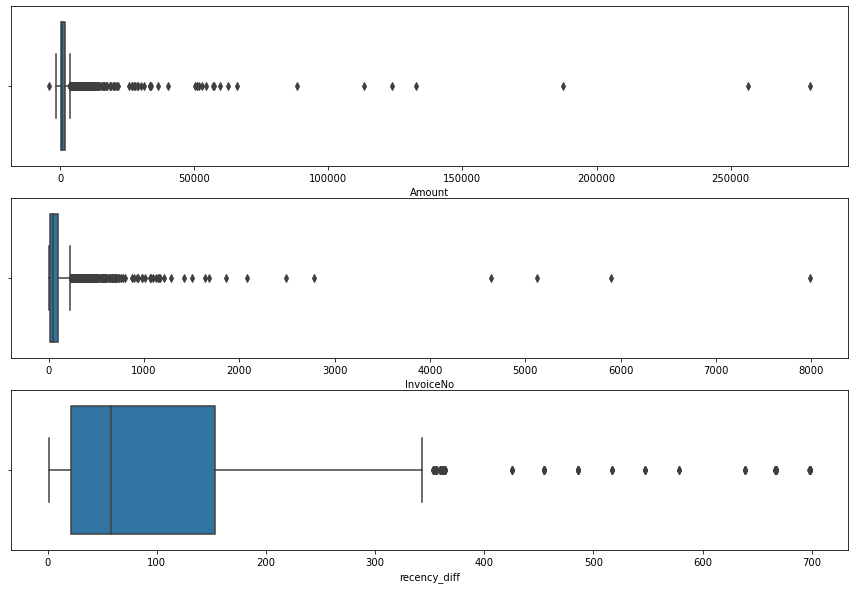

In [106]:
fig,ax=plt.subplots(3,1,figsize=(15,10))
for figu,sub in zip(df_RFM.columns.tolist(),ax.flatten()):
    figplot=sns.boxplot(df_RFM[figu],ax=sub)
    
plt.show()

In [107]:
q1=df_RFM['Amount'].quantile(0.25)
q3=df_RFM['Amount'].quantile(0.75)

iqr=q3-q1
df_RFM=df_RFM[(df_RFM['Amount']> q1-iqr)&(df_RFM['Amount']< q3+iqr)]

In [108]:
q1=df_RFM['InvoiceNo'].quantile(0.25)
q3=df_RFM['InvoiceNo'].quantile(0.75)

iqr=q3-q1
df_RFM=df_RFM[(df_RFM['InvoiceNo']> q1-iqr)&(df_RFM['InvoiceNo']< q3+iqr)]

In [109]:
q1=df_RFM['recency_diff'].quantile(0.25)
q3=df_RFM['recency_diff'].quantile(0.75)

iqr=q3-q1
df_RFM=df_RFM[(df_RFM['recency_diff']> q1-iqr)&(df_RFM['recency_diff']< q3+iqr)]

In [110]:
len(df_RFM)

3279

In [112]:
df_RFM.head()

,Amount,InvoiceNo,recency_diff
CustomerID,,,
12346.0,0.00,2,327
12348.0,1797.24,31,77
12349.0,1757.55,73,20
12350.0,334.40,17,312
12352.0,1545.41,95,74


In [117]:
df_RFM=df_RFM.reset_index()

In [118]:
df_RFM.head()

,CustomerID,Amount,InvoiceNo,recency_diff
0,12346.0,0.00,2,327
1,12348.0,1797.24,31,77
2,12349.0,1757.55,73,20
3,12350.0,334.40,17,312
4,12352.0,1545.41,95,74


In [119]:
df_RFM_new=df_RFM.drop('CustomerID',axis=1)

### Standardize the features

In [111]:
ss=StandardScaler()

In [122]:
df_RFM_new=ss.fit_transform(df_RFM_new)

In [133]:
df_RFM_new

array([[-1.14488839, -1.17307399,  2.47921736],
       [ 1.84681437, -0.29196895, -0.28630917],
       [ 1.78074602,  0.9841142 , -0.91684922],
       ...,
       [-1.01035465, -1.02115933, -1.08278081],
       [-0.85091836, -0.83886173, -0.09825336],
       [ 1.91346534,  0.89296541, -1.12702923]])

### Find the best K for KMeans

In [131]:
inertia=[]

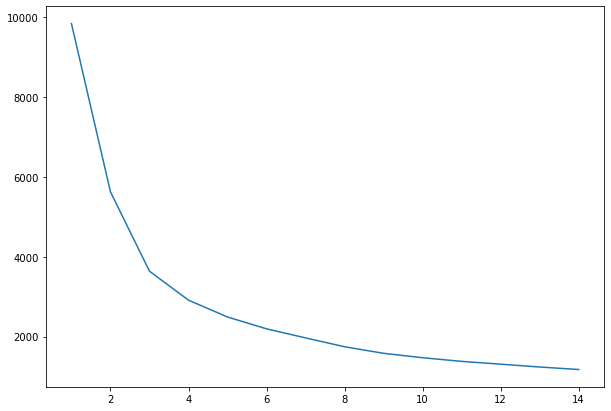

In [132]:
for x in list(range(1,15)):
    km=KMeans(n_clusters=x,max_iter=50)
    model=km.fit(df_RFM_new)
    inertia.append(model.inertia_)

plt.figure(figsize=(10,7))
plt.plot(list(range(1,15)),inertia)
plt.show()

In [137]:
km=KMeans(n_clusters=3,max_iter=50)

In [138]:
model_new=km.fit(df_RFM_new)

In [148]:
df_cluster=pd.concat([df_RFM,pd.Series(model_new.labels_)],axis=1)
df_cluster.columns=['CustomerID', 'Amount', 'Invoice Count', 'recency_diff', 'Cluster_ID']

In [149]:
df_cluster.head()

,CustomerID,Amount,Invoice Count,recency_diff,Cluster_ID
0,12346.0,0.00,2,327,0
1,12348.0,1797.24,31,77,2
2,12349.0,1757.55,73,20,2
3,12350.0,334.40,17,312,0
4,12352.0,1545.41,95,74,2


<AxesSubplot:xlabel='Cluster_ID'>

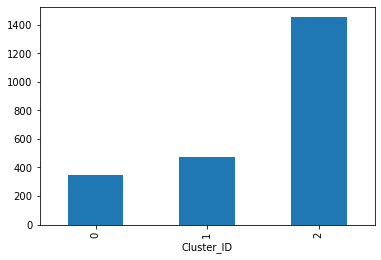

In [150]:
df_cluster.groupby('Cluster_ID')['Amount'].mean().plot(kind='bar')

<AxesSubplot:xlabel='Cluster_ID'>

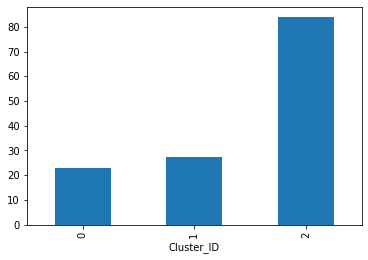

In [151]:
df_cluster.groupby('Cluster_ID')['Invoice Count'].mean().plot(kind='bar')

<AxesSubplot:xlabel='Cluster_ID'>

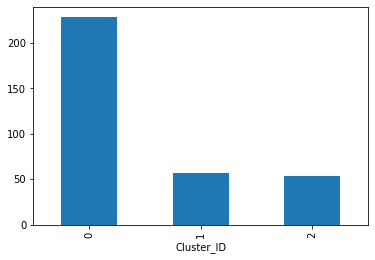

In [152]:
df_cluster.groupby('Cluster_ID')['recency_diff'].mean().plot(kind='bar')